# Classification of Pollen Carrying Bees
### M. Johnson, Feb. 28, 2019
-------

try more tranforms?
 - OWN NORM stats
 
----

- GPU 

**Optimizer:**
- SGD (over Adam)

**Batch size:**
- 32 (over 16)

----------

TODO: 
    - try to visualize layers like in:
        - https://towardsdatascience.com/visualizing-intermediate-activation-in-convolutional-neural-networks-with-keras-260b36d60d0
    

## Imports

In [1]:
%matplotlib inline
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# pip install opencv-python
import cv2 as cv

## PollenDataset
Here we create a custom Dataset object, PollenDataset, to store our data.

In [68]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset

# 
class PollenDataset(Dataset):
    """class for Pollen dataset."""
    
    # 'pollen_data.csv', base_path
    def __init__(self, csv_file, root_dir, transform=None):
        '''
        '''
        self.root_dir = root_dir
        self.imlist = glob.glob(os.path.join(root_dir, 'images', '*.jpg'))
        self.dataframe = pd.read_csv(csv_file, index_col=0)
        
        # Remove poor sample images
        removed_images = ['NP13068-42r.jpg', 'NP27452-203r.jpg', 'NP27452-204r.jpg', 'NP63758-223r.jpg']
        self.removed_df = self.dataframe[ self.dataframe['filename'].isin(removed_images)]
        
        self.dataframe[ ~self.dataframe['filename'].isin(removed_images)]
        
        self.transform = transform
        self.size =(180,300)
        
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        '''
        '''
        img_name = os.path.join(self.root_dir,
                                'images',
                                self.dataframe.iloc[idx, 0])
        
        image = cv.imread(img_name)
        image2 = cv.cvtColor(image, cv.COLOR_RGB2BGR)
        image = cv.resize(image2, self.size)

        label = self.dataframe.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
        
        return (image, label)
    
    def get_image(self, idx, removed=False):
        '''
        '''
        
        removed_dict = {False: self.dataframe, 
                        True: self.removed_df}
        
        
        img_name = os.path.join(self.root_dir,
                                'images',
                                removed_dict[removed].iloc[idx,0])
                                #self.dataframe.iloc[idx,0])
        
        image = cv.imread(img_name)
        image2 = cv.cvtColor(image, cv.COLOR_RGB2BGR)
        image = cv.resize(image2, self.size)

        label = removed_dict[removed].iloc[idx, 1]
        
        return (image, label)

# Class to display random images and labels
# data: Dataset object
def show_random_samples(data):
    
    label_dict = {0: 'No pollen', 1: 'Pollen'}
    fig = plt.figure(figsize=(12, 5))
    
    for i in range(6):
        plt.subplot(1,6,i+1)
        plt.tight_layout()
        
        idx = np.random.randint(len(data))
        image, label = data.get_image(idx)
        
        plt.imshow(image, cmap='gray', interpolation='none')
        plt.title(label_dict[label])
        plt.xticks([])
        plt.yticks([])
    fig
    
removed_images = ['NP13068-42r.jpg', 'NP27452-203r.jpg', 'NP27452-204r.jpg', 'NP63758-223r.jpg']

def show_removed_samples(data):
    
    label_dict = {0: 'No pollen', 1: 'Pollen'}
    fig = plt.figure(figsize=(8, 4))
    plt.tight_layout()
    
    for i in range(len(removed_images)):
        plt.subplot(1,len(removed_images),i+1)  
        image, label = data.get_image(i, removed=True)
        
        plt.imshow(image, cmap='gray', interpolation='none')
        plt.title(label_dict[label] + '\n' + removed_images[i])
        plt.xticks([])
        plt.yticks([])
    fig

## Transforms

In [79]:
from torchvision import transforms

# for getting mean and std from training data
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

# once statistics are obtained, normalize data 
transforms = transforms.Compose([transforms.ToPILImage(),
                                 transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.ToTensor(),
                                 transforms.Normalize(
                                     mean=[0.24437463, 0.31319633, 0.34366167],
                                     std=[0.12024293, 0.12862892, 0.18092])
                                ])

## Instantiate the Dataset

In [80]:
pollen_data = PollenDataset(csv_file='pollen_data.csv',
                            root_dir='/home/mjohnson/Assignment2/PollenDataset',
                            transform=transforms)

#### A look at some samples:

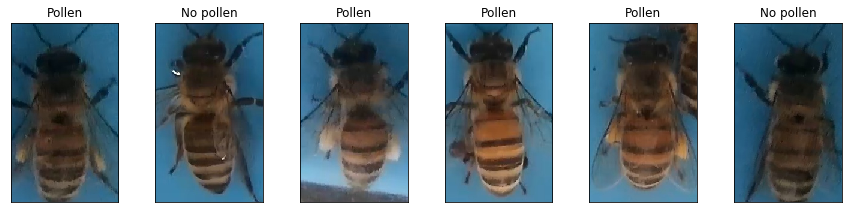

In [81]:
show_random_samples(pollen_data)

Potential removals:
    - NP13068-42r.jpg
    - NP27452-203r.jpg
    - NP27452-204r.jpg
    - NP63758-223r.jpg <- definitely this one, image has text overlay on it
    - P52861-34r.jpg - also has text overlay, not as bad though ( not removed)

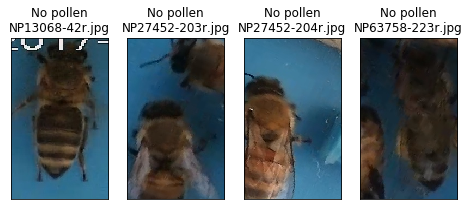

In [82]:
show_removed_samples(pollen_data)

## Data Loaders

In [96]:
from torch.utils.data.sampler import SubsetRandomSampler

validation_indices = []

def get_training_and_validation_loaders(dataset, batch_size = 16, validation_split = .2):
    
    shuffle_dataset = True
    random_seed = 8

    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))

    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)
        
    train_indices, val_indices = indices[split:], indices[:split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                               sampler=train_sampler)
    validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=valid_sampler)
    #
    validation_indices.append(val_indices)
    
    return train_loader, validation_loader       

## Model Building:
- 3 Conv layers
- 3 Fully connected layers
- Relus
- 4 MPs

In [84]:
# CNN
#
import torch.nn as nn

class BeeNet(nn.Module):
    def __init__(self):
        super(BeeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5)
        self.fc1 = nn.Linear(128*17*9, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #print(x.shape) # [N, 64, 72, 42]
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        #print(x.shape) # [N, 128, 34, 19]
        x = F.relu(F.max_pool2d(x, 2))
        #print(x.shape) # [N, 128, 17, 9]
        x = x.view(-1, 128*17*9)
        #print(x.shape) # 
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        #print(x.shape)
        return F.log_softmax(x, dim=1)

    def name(self):
        return "BeeNet_f28_gpu3"

In [95]:
validation_indices

[]

### Data Normalization

This function was implemented in a prior notebook and results were obtained to create a new Dataset.

In [26]:
# code from: https://forums.fast.ai/t/image-normalization-in-pytorch/7534
def get_norm_statistics(dataset, batch_size=64):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    pop_mean = []
    pop_std0 = []
    pop_std1 = []

    for i, (images, labels) in enumerate(dataloader):
        # shape (batch_size, 3, height, width)

        numpy_image = images.numpy()

        # shape (3,)
        batch_mean = np.mean(numpy_image, axis=(0,2,3))
        batch_std0 = np.std(numpy_image, axis=(0,2,3))
        batch_std1 = np.std(numpy_image, axis=(0,2,3), ddof=1)

        pop_mean.append(batch_mean)
        pop_std0.append(batch_std0)
        pop_std1.append(batch_std1)

    # shape (num_iterations, 3) -> (mean across 0th axis) -> shape (3,)
    pop_mean = np.array(pop_mean).mean(axis=0)
    pop_std0 = np.array(pop_std0).mean(axis=0)
    pop_std1 = np.array(pop_std1).mean(axis=0)

    return pop_mean, pop_std1

### Model training:
- Note: creates different training/validation sets each time so not to be used with loaded model unless we specify validation set:
    - TODO: specify validation set in way to reuse ?

In [85]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 
train_loader, validation_loader = get_training_and_validation_loaders(pollen_data, batch_size=32)

device

In [87]:
# HPs
lr = 0.01 # 0.001 too small
momentum = 0.9

# Model
model = BeeNet().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=momentum)

loss_list = []
acc_list = []
train_losses = []
train_accuracies = []
train_losses2 = []
#
num_epochs = 50
for epoch in range(num_epochs):
    
    
    # Train:   
    total = 0
    correct = 0
    trainlosses = []
    
    for batch_index, (images, labels) in enumerate(train_loader):
        # Send to GPU (device)
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images.float())
        
        # Loss
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        trainlosses.append(loss.item())
        
        # Compute accuracy
        _, argmax = torch.max(outputs, 1)
        correct += (labels == argmax).sum().item() #.mean()
        total += len(labels)
        
    train_losses.append( np.mean(trainlosses) )
    train_accuracies.append( correct/total )
    train_losses2.extend(trainlosses)
                        
    with torch.no_grad():
        
        losses = []
        total = 0
        correct = 0
    
        for images, labels in validation_loader:
            # 
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images.float())
            
            loss = criterion(outputs, labels)
        
            # Compute accuracy
            _, argmax = torch.max(outputs, 1)
            correct += (labels == argmax).sum().item() #.mean()
            total += len(labels)
            
            losses.append(loss.item())
    
        acc = np.round(correct/total, 3)
        loss = np.mean(losses)
        
        acc_list.append(acc)
        loss_list.append(loss)
            
        # F-Strings (3.6+)
        #try:
            #print(f'Step [{epoch+1}/{num_epochs}]')
            #print(f'Loss: {np.mean(losses):.4}, Acc: {correct/total:.2f}')
        #except:
        print('Step', epoch+1, '/', num_epochs, '  ',
              'Loss:', np.round(np.mean(losses), 2), 'Acc:', np.round((correct/total), 2))

Step 1 / 50    Loss: 0.72 Acc: 0.44
Step 2 / 50    Loss: 0.73 Acc: 0.52
Step 3 / 50    Loss: 0.42 Acc: 0.83
Step 4 / 50    Loss: 0.37 Acc: 0.85
Step 5 / 50    Loss: 0.37 Acc: 0.87
Step 6 / 50    Loss: 0.46 Acc: 0.74
Step 7 / 50    Loss: 0.29 Acc: 0.85
Step 8 / 50    Loss: 0.25 Acc: 0.87
Step 9 / 50    Loss: 0.35 Acc: 0.87
Step 10 / 50    Loss: 0.3 Acc: 0.87
Step 11 / 50    Loss: 0.32 Acc: 0.87
Step 12 / 50    Loss: 0.31 Acc: 0.89
Step 13 / 50    Loss: 0.27 Acc: 0.89
Step 14 / 50    Loss: 0.27 Acc: 0.85
Step 15 / 50    Loss: 0.31 Acc: 0.82
Step 16 / 50    Loss: 0.28 Acc: 0.91
Step 17 / 50    Loss: 0.24 Acc: 0.9
Step 18 / 50    Loss: 0.24 Acc: 0.91
Step 19 / 50    Loss: 0.22 Acc: 0.92
Step 20 / 50    Loss: 0.31 Acc: 0.91
Step 21 / 50    Loss: 0.21 Acc: 0.94
Step 22 / 50    Loss: 0.18 Acc: 0.94
Step 23 / 50    Loss: 0.24 Acc: 0.89
Step 24 / 50    Loss: 0.27 Acc: 0.89
Step 25 / 50    Loss: 0.19 Acc: 0.92
Step 26 / 50    Loss: 0.37 Acc: 0.91
Step 27 / 50    Loss: 0.34 Acc: 0.89
Step 28 / 50

## Visualizing Loss and Accuracy

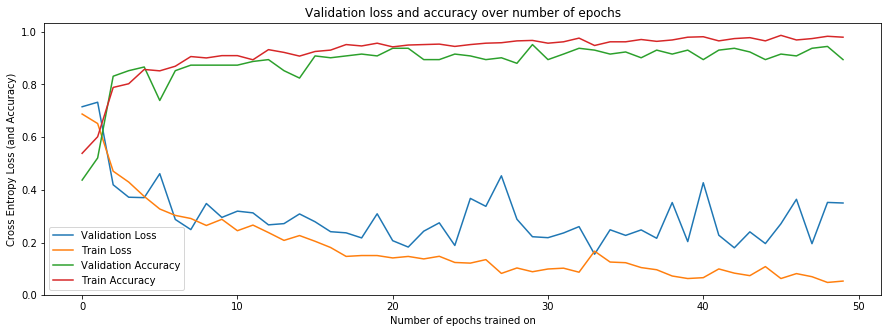

In [88]:
plt.subplots(figsize=(15,5))
plt.plot(loss_list); # blue
plt.plot(train_losses);
plt.plot(acc_list); # orange
plt.plot(train_accuracies);
plt.title('Validation loss and accuracy over number of epochs');
plt.xlabel('Number of epochs trained on');
plt.ylabel('Cross Entropy Loss (and Accuracy)');
plt.legend(['Validation Loss', 'Train Loss', 'Validation Accuracy', 'Train Accuracy'], loc='lower left');

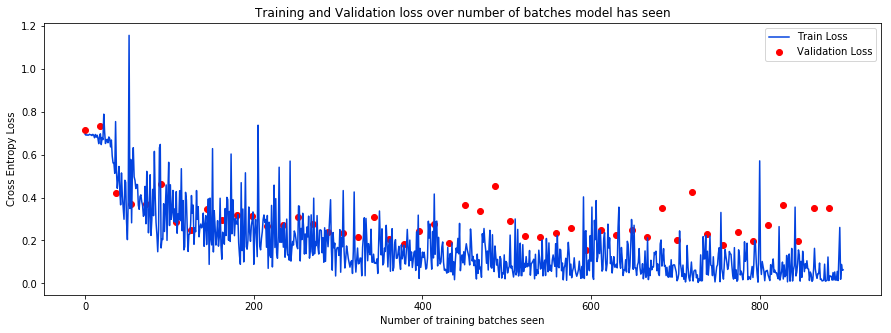

In [89]:
loader_len = len(train_loader)
x_vals= [loader_len*i for i in range(num_epochs)]
y_vals = loss_list

plt.subplots(figsize=(15,5))
plt.plot(train_losses2, color='xkcd:blue');
plt.scatter(x=x_vals, y=loss_list, color='red'); # validation losses
#plt.scatter(x=x_vals, y=acc_list, color='xkcd:green') # accs
plt.title('Training and Validation loss over number of batches model has seen');
plt.xlabel('Number of training batches seen');
plt.ylabel('Cross Entropy Loss');
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right');

### - Looks like it may be starting to overfit after ~ 300 batches



<br>

In [90]:
torch.save(model.state_dict(), 'f28_BeeNet_sgd3.pth')
torch.save(optimizer.state_dict(), 'f28_optim_sgd3.pth')

## Images (normalized) with corresponding predictions

In [92]:
import warnings
warnings.filterwarnings('ignore')
                        
def show_predictions(rows=2):
    
    with torch.no_grad():
    
        # Chooose a random batch from validation loader to predict
        which_iter = np.random.randint(len(validation_loader))
        valid_iter = iter(validation_loader)
        for i in range(which_iter-1):
            next(valid_iter)

        # Fetch images and labels from batch
        images, labels = next(valid_iter)
        images, labels = images.to(device), labels.to(device)
        # 
        #outputs = model(images.permute(0, 3, 2, 1).float())
        outputs = model(images.float())
        predictions = torch.max(outputs, 1)[1]
        predictions = predictions.cpu().numpy()

        labels = labels.cpu().numpy()

        # Dict for Labelling Images
        label_dict = {0: 'No pollen', 1: 'Pollen'}
        color_dict = {True: 'green', False: 'red'}
        
        fig = plt.figure(figsize=(15, 6))

        for i in range(6*rows):
            plt.subplot(rows,6,i+1)
            plt.tight_layout()

            image, label, pred = images[i], labels[i], predictions[i]

            plt.imshow(image.permute(1,2,0).cpu().numpy(), cmap='gray', interpolation='none')
            
            plt.title('Label:' + label_dict[label] + '\nPred:' + label_dict[pred], 
                      color=color_dict[(label_dict[label] == label_dict[pred])])
            plt.xticks([])
            plt.yticks([])
        fig

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

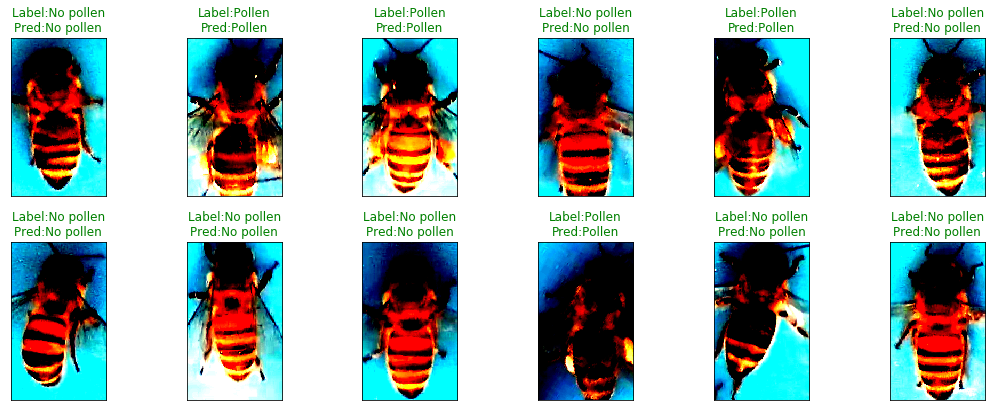

In [93]:
show_predictions()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

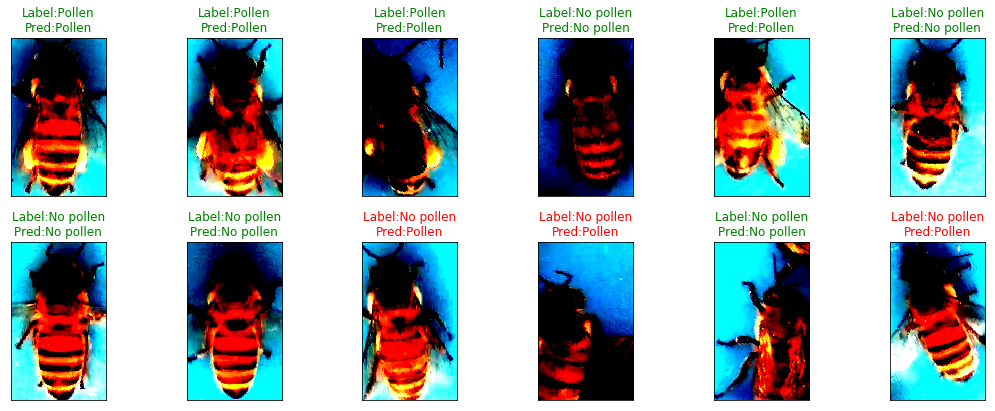

In [94]:
show_predictions()

## Not very useful?

<Figure size 432x288 with 0 Axes>

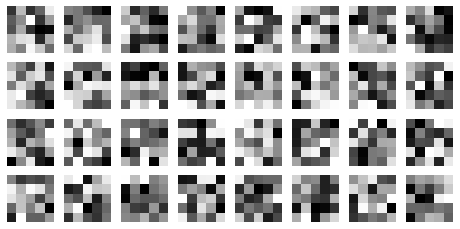

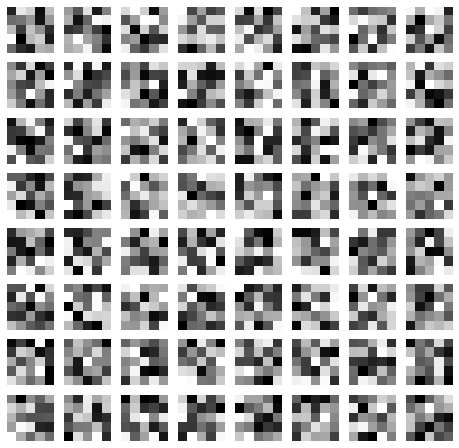

In [18]:
# code from: 
# https://medium.com/ml2vec/intro-to-pytorch-with-image-classification-on-a-fashion-clothes-dataset-e589682df0c5
def plot_kernels(tensor, num_cols=6):
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(num_kernels):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i][0,:,:], cmap='gray')
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()
filters = model.modules();
model_layers = [i for i in model.children()];
first_layer = model_layers[0];
second_layer = model_layers[1];
first_kernels = first_layer.weight.data.cpu().numpy()
plot_kernels(first_kernels, 8);
second_kernels = second_layer.weight.data.cpu().numpy()
plot_kernels(second_kernels, 8);

In [19]:
first_layer.weight.data.cpu().numpy().shape

(32, 3, 5, 5)

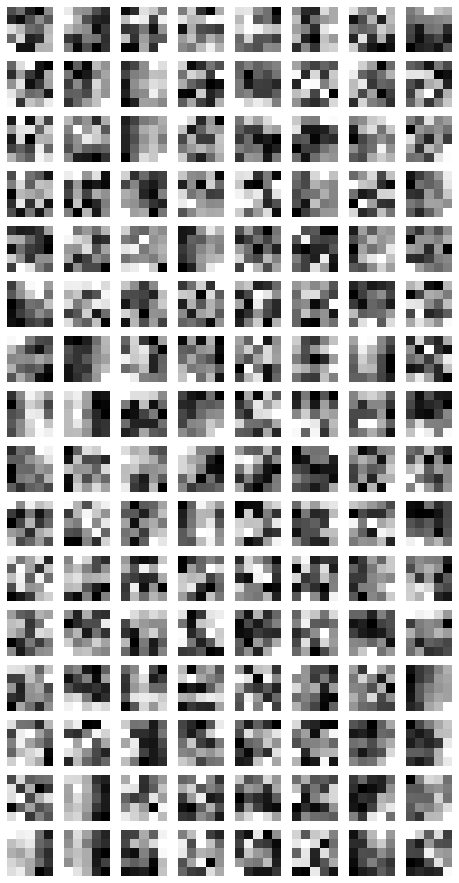

In [20]:
third_layer = model_layers[3];
third_kernels = third_layer.weight.data.cpu().numpy()
plot_kernels(third_kernels, 8);

In [21]:
second_kernels.shape

(64, 32, 5, 5)

In [22]:
third_kernels.shape

(128, 64, 5, 5)